In [1]:
# -*- coding: utf-8 -*-
# @author: tongzi
# @description: Learing best practices for model evaluation and hyperparameter tuning
# @created date: 2019/08/30
# @last modification: 2019/08/30

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**In this chapter, we will learn how to:  
(1) Obtain unbiased estimation of a model's performance  
(2) Diagnose the common problem of maching learning algorithms  
(3) Fine-tune machine learning models  
(4) Evaluate predictive models using different performance metrics**

### Loading the Breast Cancer Wisconsin dataset

In [3]:
df = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header=None)

In [4]:
from sklearn.preprocessing import LabelEncoder

In [6]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
# malignant (M) is represented as class 1, benign (B) is represented as class 0
le.transform(['M', 'B']) 

array([1, 0], dtype=int64)

In [10]:
from sklearn.cross_validation import train_test_split

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test =  \
train_test_split(X, y, test_size=0.2, random_state=1)

### Combining transformers and estimators in a pipeline

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [15]:
from sklearn.pipeline import Pipeline

In [18]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(random_state=1))])

In [19]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [22]:
print(f'Test accuracy: {pipe_lr.score(X_test, y_test):.3f}')

Test accuracy: 0.947


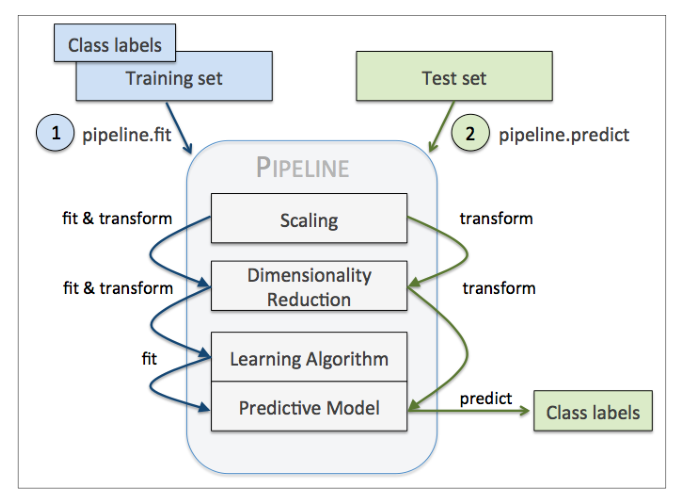

### Using k-fold cross-validation to assess model performance

In [23]:
from sklearn.model_selection import StratifiedKFold

In [26]:
kfold = StratifiedKFold(n_splits=10, random_state=1)

In [31]:
scores =[]
for k, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train_index], y_train[train_index])
    score = pipe_lr.score(X_train[test_index], y_train[test_index])
    scores.append(score)
    print(f'Fold: {k+1}, Class dist: {np.bincount(y_train[train_index])}, Acc: {score:.3f}')

Fold: 1, Class dist: [256 153], Acc: 0.891
Fold: 2, Class dist: [256 153], Acc: 0.978
Fold: 3, Class dist: [256 153], Acc: 0.978
Fold: 4, Class dist: [256 153], Acc: 0.913
Fold: 5, Class dist: [256 153], Acc: 0.935
Fold: 6, Class dist: [257 153], Acc: 0.978
Fold: 7, Class dist: [257 153], Acc: 0.933
Fold: 8, Class dist: [257 153], Acc: 0.956
Fold: 9, Class dist: [257 153], Acc: 0.978
Fold: 10, Class dist: [257 153], Acc: 0.956


In [34]:
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.950 +/- 0.029


Although the previous code example was useful to illustrate how k-fold
cross-validation works, scikit-learn also implements a k-fold cross-validation
scorer, which allows us to evaluate our model using stratified k-fold
cross-validation more efficiently:

In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)

In [38]:
print(f"cross-validation accuracy scores: {scores}")

cross-validation accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]


In [40]:
print(f'cross-validation accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

cross-validation accuracy: 0.950 +/- 0.029


### Dignosing bias and variance problems with learning curves

In [41]:
from sklearn.learning_curve import learning_curve

C:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [42]:
from sklearn.model_selection import learning_curve

In [44]:
pipe_lr = Pipeline([('scl', StandardScaler()), 
                   ('clf', LogisticRegression(penalty='l2', random_state=0))])

In [47]:
train_sizes, train_scores, test_scores = \
learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
              train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

In [48]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

(0.8, 1.0)

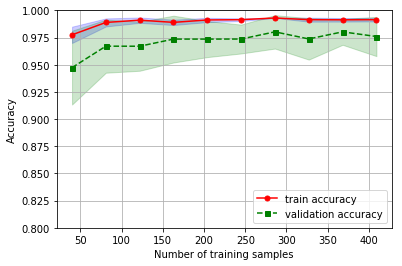

In [53]:
plt.plot(train_sizes, train_mean, color='red', marker='o', markersize=5, 
         label='train accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, 
         label='validation accuracy', linestyle='--')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                alpha=0.2, color='green')
plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])

### Addressing overfitting and underfitting with validation curves

In [55]:
from sklearn.model_selection import validation_curve

In [60]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = \
validation_curve(estimator=pipe_lr, X=X_train, y=y_train,
              param_name='clf__C', param_range=param_range, cv=10)

In [61]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

(0.8, 1.0)

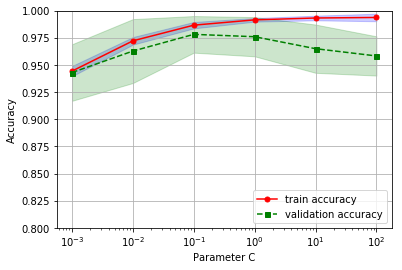

In [64]:
plt.plot(param_range, train_mean, color='red', marker='o', markersize=5, 
         label='train accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std,
                alpha=0.2, color='blue')

plt.plot(param_range, test_mean, color='green', marker='s', markersize=5, 
         label='validation accuracy', linestyle='--')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std,
                alpha=0.2, color='green')
plt.grid(True)
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])